# Confidence Intervals

This notebook overviews three types of intervals that scalecast offers across several model classes and three different datasets. The efficacy of each interval is scored with [Mean Scaled Interval Score (MSIS)](https://scalecast.readthedocs.io/en/latest/Forecaster/Util.html#src.scalecast.util.metrics.msis). Requires `scalecast>=0.16.4`.  

**Definition of terms:**  

* ***Bootstrapped Intervals (default):***  
  - This is a computationally cheap method that works by drawing randomly from in-sample residuals and measuring distance from actual values.  
  - It is not dynamic (interval ranges are constant throughout a given horizon).  
  - Models that are overfit usually get an extremely tight (and inaccurate) confidence interval.  
  - All scalecast models get this interval by default for any model run with `auto_forecast()` or `manual_forecast()`.  
* ***Naive Intervals:***
  - This method determines a range of possible values within a given certainty for out-of-sample point predictions by measuring how far different model classes' precitions are from one another in each step of a given horizon.  
  - It can create a dynamic interval that expands as predictions move further out.  
  - If you call a diverse set of models on the same series, this method could give a robust interval.  
  - If models are very close to each other but very far from an actual value, it will give an interval that is too tight.  
  - If one model is an outlier in how close or far it is from actual values, it can skew all confidence intervals.  
  - In scalecast, it is computationally cheap and has to be called explicitly in order for models to receive it.  
  - In the examples explored in this notebook, **the default interval was generally slightly better.**  
* ***Backtested Intervals:***
  - This method determines confidence intervals by backtesting a given model on out-of-sample forecast horizons.
  - The ranges of the resulting confidence intervals are determined by the standard deviation of each step in each backtest iteration.  
  - This is a computationally expensive method but it results in a dynamic interval that is **generally better than the bootstrapped and naive methods.**
* ***Probabilistic Intervals:***
  - This method construcsts intervals using conformal prediction from the [mapie](https://github.com/scikit-learn-contrib/MAPIE) package.
  - Conformal prediction is considered state-of-the-art for constructing time-series confidence intervals.
  - It is a technique that considers the trained model itself and its strengths/limitations in predicting unseen data.
  - It is a computationally cheap method and **it was the best-performing interval** explored in this example.
  - It does come with its downsides as implemented in scalecast -- it can't evaluate over small test sets and it is only currently available for scikit-learn model classes.
  
Each one of these intervals were better than and worse than the others at times (according to MSIS) depending on the series being forecast and the model. To evaluate the intervals, we leave out a section of each series to score out-of-sample. This is usually not necessary for scalecast, as all models are tested automatically, but the confidence intervals can overfit on any test set stored in the `Forecaster` object due to leakage that occurs when constructing these intervals. Scalecast intervals are compared to ARIMA intervals on the same series in the last section of this notebook. The series used in this example are ordered from easiest-to-hardest to forecast. Different results could be obtained if certain parameters are changed, such as the model classes used and the number of backtest iterations for that interval type.  

**Sections:**  
[Daily Website Visitors](#Daily-Website-Visitors)  
[Housing Starts](#Housing-Starts)  
[Avocado Sales](#Avocado-Sales)  
[All Aggregated Results](#All-Aggregated-Results)  
[Benchmark Against StatsModels ARIMA](#Benchmark-Against-StatsModels-ARIMA)  

In [1]:
import pandas as pd
import numpy as np
from scalecast.Forecaster import Forecaster
from scalecast import GridGenerator
from scalecast.util import metrics
from scalecast.notebook import tune_test_forecast
import matplotlib.pyplot as plt
import seaborn as sns
import time
from tqdm.notebook import tqdm

In [2]:
models = (
    'mlr',
    'elasticnet',
    'ridge',
    'knn',
    'xgboost',
    'lightgbm',
    'gbt',
) # these are all scikit-learn models or APIs

results_template = pd.DataFrame(index=models)

In [3]:
def score_cis(results, fcsts, ci_name, actuals, obs, val_len, models=models, m_=1):
    for m in models:
        results.loc[m,ci_name] = metrics.msis(
            a = actuals,
            uf = fcsts[m+'_upperci'],
            lf = fcsts[m+'_lowerci'],
            obs = obs,
            m = m_,
        )
    return results

In [4]:
GridGenerator.get_example_grids()

## Daily Website Visitors

- Link to data: https://www.kaggle.com/datasets/bobnau/daily-website-visitors  
- We will use a length of 180 observations (about half a year) both to tune and test the models  
- We want to optimize the forecasts and confidence intervals for a 60-day forecast horizon  

In [5]:
val_len = 180
fcst_len = 60

In [6]:
data = pd.read_csv('daily-website-visitors.csv',parse_dates=['Date']).set_index('Date')
data.head()

,Row,Day,Day.Of.Week,Page.Loads,Unique.Visits,First.Time.Visits,Returning.Visits
Date,,,,,,,
2014-09-14,1,Sunday,1,"2,146","1,582",1430,152
2014-09-15,2,Monday,2,"3,621","2,528",2297,231
2014-09-16,3,Tuesday,3,"3,698","2,630",2352,278
2014-09-17,4,Wednesday,4,"3,667","2,614",2327,287
2014-09-18,5,Thursday,5,"3,316","2,366",2130,236


In [7]:
visits_sep = data['First.Time.Visits'].iloc[-fcst_len:]
visits = data['First.Time.Visits'].iloc[:-fcst_len]

In [8]:
f=Forecaster(
    y=visits,
    current_dates=visits.index,
    future_dates=fcst_len
)
f.set_test_length(val_len)
f.set_validation_length(val_len)
f.auto_Xvar_select(
    estimator='elasticnet',
    alpha=.2,
    max_ar=100,
    monitor='ValidationMetricValue', # not test set
)
f

Forecaster(
    DateStartActuals=2014-09-14T00:00:00.000000000
    DateEndActuals=2020-06-20T00:00:00.000000000
    Freq=D
    N_actuals=2107
    ForecastLength=60
    Xvars=['t', 'AR1', 'AR2', 'AR3', 'AR4', 'AR5', 'AR6', 'AR7', 'AR8', 'AR9', 'AR10', 'AR11', 'AR12', 'AR13', 'AR14', 'AR15', 'AR16', 'AR17', 'AR18', 'AR19', 'AR20', 'AR21', 'AR22', 'AR23', 'AR24', 'AR25', 'AR26', 'AR27', 'AR28', 'AR29', 'AR30', 'AR31', 'AR32', 'AR33', 'AR34', 'AR35', 'AR36', 'AR37', 'AR38', 'AR39', 'AR40', 'AR41', 'AR42', 'AR43', 'AR44', 'AR45', 'AR46', 'AR47', 'AR48', 'AR49', 'AR50', 'AR51', 'AR52', 'AR53', 'AR54', 'AR55', 'AR56', 'AR57', 'AR58', 'AR59', 'AR60', 'AR61', 'AR62', 'AR63', 'AR64', 'AR65', 'AR66', 'AR67', 'AR68', 'AR69', 'AR70', 'AR71', 'AR72', 'AR73', 'AR74', 'AR75', 'AR76', 'AR77', 'AR78', 'AR79', 'AR80', 'AR81', 'AR82', 'AR83', 'AR84', 'AR85', 'AR86', 'AR87', 'AR88', 'AR89', 'AR90', 'AR91', 'AR92', 'AR93', 'AR94', 'AR95', 'AR96', 'AR97', 'AR98', 'AR99', 'AR100']
    Differenced=0
    TestLe

In [9]:
tune_test_forecast(
    f,
    models,
    dynamic_testing = fcst_len,
)

  0%|          | 0/7 [00:00<?, ?it/s]

In [10]:
ms = f.export('model_summaries',determine_best_by='TestSetMAE')
best_model = ms['ModelNickname'].values[0]
ms[['ModelNickname','TestSetMAE','InSampleMAE']]

,ModelNickname,TestSetMAE,InSampleMAE
0,xgboost,345.792972,11.628271
1,lightgbm,461.362673,85.150035
2,elasticnet,541.722274,139.726881
3,ridge,543.778908,139.716351
4,mlr,547.506781,140.103644
5,knn,671.790741,217.559589
6,gbt,840.033655,113.251078


We will demonstrate how the confidence intervals change as they are re-evaluated using the best model according to the test MAE: xgboost.

### Bootstrapped Interval (default)

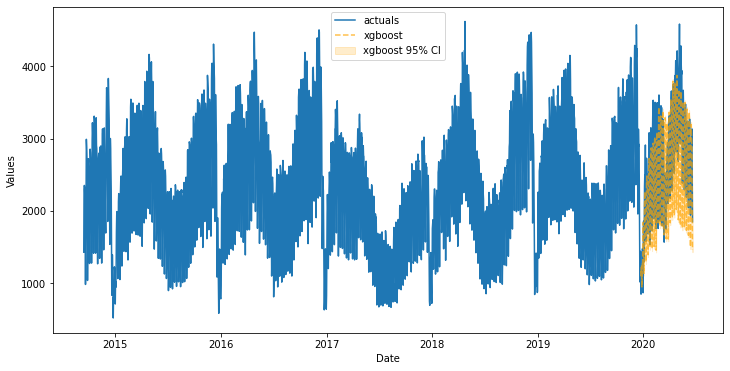

In [11]:
f.plot_test_set(ci=True,models=best_model)
plt.show()

XGBoost overfit on this dataset, so its default confidence interval is barely noticeable. That is one of the downsides of the bootstrapped method from in-sample residuals.

In [12]:
# export test-set preds and confidence intervals
fcsts1 = f.export("lvl_fcsts",cis=True)
fcsts1.head()

,DATE,xgboost,xgboost_upperci,xgboost_lowerci,lightgbm,lightgbm_upperci,lightgbm_lowerci,elasticnet,elasticnet_upperci,elasticnet_lowerci,...,ridge_lowerci,mlr,mlr_upperci,mlr_lowerci,knn,knn_upperci,knn_lowerci,gbt,gbt_upperci,gbt_lowerci
0,2020-06-21,2028.825562,2060.075896,1997.575227,2198.858468,2395.067909,2002.649027,2199.951838,2569.139855,1830.763820,...,1779.065054,2190.555279,2544.491438,1836.619121,2080.476190,2697.085042,1463.867339,2125.968510,2419.164323,1832.772698
1,2020-06-22,2720.898438,2752.148772,2689.648103,2820.575637,3016.785078,2624.366196,2837.629387,3206.817404,2468.441370,...,2421.209628,2835.674158,3189.610316,2481.737999,2962.142857,3578.751709,2345.534006,2729.050006,3022.245819,2435.854194
2,2020-06-23,2845.472412,2876.722746,2814.222078,2819.654176,3015.863617,2623.444735,2963.220499,3332.408517,2594.032482,...,2561.309334,2975.510723,3329.446882,2621.574565,3038.095238,3654.704090,2421.486387,2880.262061,3173.457874,2587.066249
3,2020-06-24,2904.729492,2935.979826,2873.479158,2824.992206,3021.201647,2628.782765,3026.889266,3396.077283,2657.701248,...,2624.115935,3038.258157,3392.194315,2684.321998,3128.095238,3744.704090,2511.486387,2930.293895,3223.489708,2637.098083
4,2020-06-25,2986.020996,3017.271330,2954.770662,2961.588543,3157.797985,2765.379102,3024.266925,3393.454943,2655.078908,...,2613.354801,3032.580568,3386.516727,2678.644410,2796.857143,3413.465994,2180.248291,3029.007375,3322.203188,2735.811562


The values in the below table are [mean scaled interval scores](https://scalecast.readthedocs.io/en/latest/Forecaster/Util.html#src.scalecast.util.metrics.msis) for confidence intervals. Lower scores are better.

In [13]:
results = score_cis(
    results_template.copy(),
    fcsts1,
    'Bootstrapped (Default)',
    visits_sep,
    visits,
    val_len = val_len,
)
results

,Bootstrapped (Default)
mlr,4.150189
elasticnet,4.001752
ridge,3.726014
knn,3.593727
xgboost,21.660044
lightgbm,14.669521
gbt,7.501384


### Naive Interval

- `Forecaster.reeval_cis()` [documentation](https://scalecast.readthedocs.io/en/latest/Forecaster/Forecaster.html#src.scalecast.Forecaster.Forecaster.reeval_cis)  

In [14]:
%%time
f.reeval_cis()

Wall time: 2.45 s


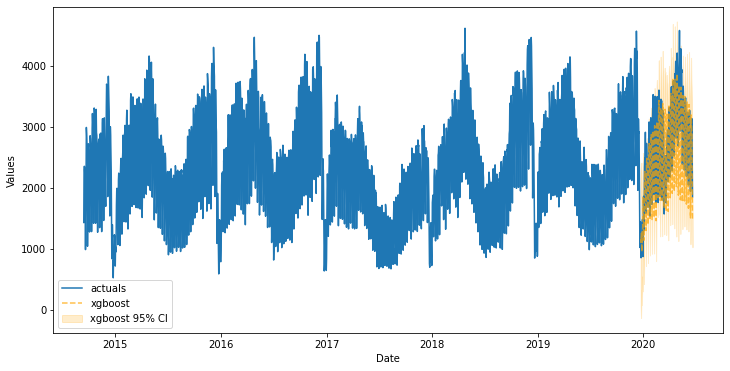

In [15]:
f.plot_test_set(ci=True,models=best_model)
plt.show()

The confidence interval is noticeable now and is dynamic -- for some observations it is further out from the point estimate than others. It has been constructed based on the dispersion of the point estimates from the other evaluated models.

In [16]:
fcsts2 = f.export("lvl_fcsts",cis=True)
results = score_cis(
    results,
    fcsts2,
    'Naive',
    visits_sep,
    visits,
    val_len = val_len,
)
results

,Bootstrapped (Default),Naive
mlr,4.150189,5.557751
elasticnet,4.001752,5.510649
ridge,3.726014,5.532300
knn,3.593727,4.123267
xgboost,21.660044,6.532696
lightgbm,14.669521,7.180963
gbt,7.501384,5.214933


### Backtested Interval

In [17]:
%%time
f.reeval_cis(method='backtest',jump_back=fcst_len)

Wall time: 3min 21s


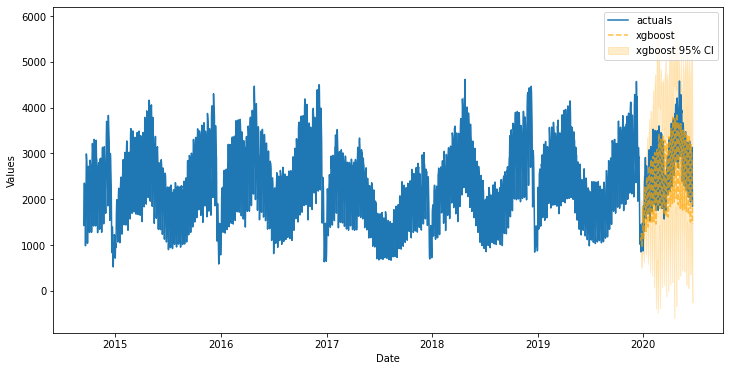

In [18]:
f.plot_test_set(ci=True,models=best_model)
plt.show()

This is also a dynamic confidence interval, but is obtained solely from XGBoost's own point estimates over 10 test sets in the data. The first point's interval is based on the standard deviation of the residual for all 10 tests of the first step, same for the second point and beyond.  

In [19]:
fcsts3 = f.export("lvl_fcsts",cis=True)
results = score_cis(
    results,
    fcsts3,
    'Backtest',
    visits_sep,
    visits,
    val_len = val_len,
)
results

,Bootstrapped (Default),Naive,Backtest
mlr,4.150189,5.557751,4.795872
elasticnet,4.001752,5.510649,4.789591
ridge,3.726014,5.532300,4.801673
knn,3.593727,4.123267,4.515227
xgboost,21.660044,6.532696,5.129796
lightgbm,14.669521,7.180963,4.587335
gbt,7.501384,5.214933,5.286061


### Probabilistic Interval
- `Forecaster.proba_forecast()` [documentation](https://scalecast.readthedocs.io/en/latest/Forecaster/Forecaster.html#src.scalecast.Forecaster.Forecaster.proba_forecast).

In [20]:
for m in tqdm(models):
    f.set_estimator(m)
    f.proba_forecast(
        **ms.loc[ms['ModelNickname'] == m, 'HyperParams'].values[0], # grab the already-optimized hyperparams
        dynamic_testing = fcst_len,
    )

  0%|          | 0/7 [00:00<?, ?it/s]

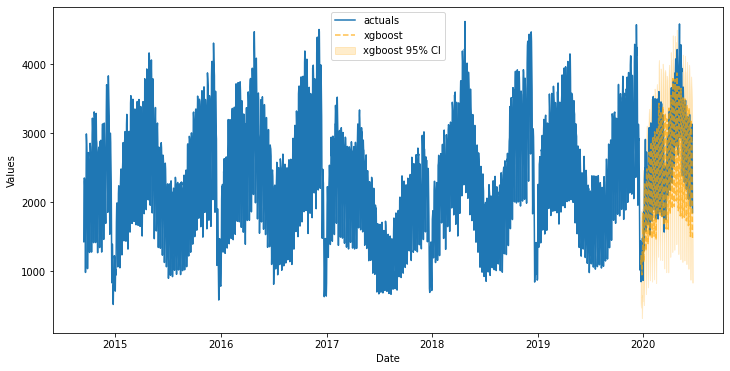

In [21]:
f.plot_test_set(ci=True,models=best_model)
plt.show()

In [22]:
fcsts4 = f.export("lvl_fcsts",cis=True)
results = score_cis(
    results,
    fcsts4,
    'Probabilistic',
    visits_sep,
    visits,
    val_len = val_len,
)
results

,Bootstrapped (Default),Naive,Backtest,Probabilistic
mlr,4.150189,5.557751,4.795872,3.576653
elasticnet,4.001752,5.510649,4.789591,3.509380
ridge,3.726014,5.532300,4.801673,3.575989
knn,3.593727,4.123267,4.515227,4.189418
xgboost,21.660044,6.532696,5.129796,5.323570
lightgbm,14.669521,7.180963,4.587335,5.678573
gbt,7.501384,5.214933,5.286061,3.230711


### Aggregated Results  

- Which type generally led to the best MSIS score?  
- For website visitors, it was the backtest method.  

In [23]:
ci_type_score = results.mean()
ci_type_score.sort_values()

Probabilistic             4.154899
Backtest                  4.843650
Naive                     5.664651
Bootstrapped (Default)    8.471804
dtype: float64

In [24]:
model_score = results.mean(axis=1)
model_score.sort_values()

knn           4.105410
ridge         4.408994
elasticnet    4.452843
mlr           4.520116
gbt           5.308272
lightgbm      8.029098
xgboost       9.661526
dtype: float64

## Housing Starts  

- Link to data: https://fred.stlouisfed.org/series/HOUSTNSA  
- We will use a length of 96 observations (8 years) both to tune and test the models  
- We want to optimize the forecasts and confidence intervals for a 24-month forecast horizon  

In [25]:
import pandas_datareader as pdr

In [26]:
val_len = 96
fcst_len = 24

In [27]:
housing = pdr.get_data_fred('HOUSTNSA',start='1900-01-01',end='2021-06-01')

In [28]:
starts_sep = housing.iloc[-fcst_len:,0]
starts = housing.iloc[:-fcst_len,0]

In [29]:
f = Forecaster(
    y=starts,
    current_dates=starts.index,
    future_dates=fcst_len,
)

f.set_test_length(val_len)
f.set_validation_length(val_len)
f.diff()
f.auto_Xvar_select(
    estimator='elasticnet',
    alpha=.2,
    max_ar=100,
    monitor='ValidationMetricValue', # not test set
)
f

Forecaster(
    DateStartActuals=1959-01-01T00:00:00.000000000
    DateEndActuals=2019-06-01T00:00:00.000000000
    Freq=MS
    N_actuals=726
    ForecastLength=24
    Xvars=['monthsin', 'monthcos', 'quartersin', 'quartercos', 'AR1', 'AR2', 'AR3', 'AR4', 'AR5', 'AR6', 'AR7', 'AR8', 'AR9', 'AR10', 'AR11', 'AR12', 'AR13', 'AR14', 'AR15', 'AR16', 'AR17', 'AR18', 'AR19', 'AR20', 'AR21', 'AR22', 'AR23', 'AR24', 'AR25', 'AR26', 'AR27', 'AR28', 'AR29', 'AR30', 'AR31', 'AR32', 'AR33', 'AR34', 'AR35', 'AR36', 'AR37', 'AR38', 'AR39', 'AR40', 'AR41', 'AR42', 'AR43', 'AR44', 'AR45', 'AR46', 'AR47', 'AR48', 'AR49', 'AR50', 'AR51', 'AR52', 'AR53', 'AR54', 'AR55', 'AR56', 'AR57', 'AR58', 'AR59', 'AR60', 'AR61', 'AR62', 'AR63', 'AR64', 'AR65', 'AR66', 'AR67', 'AR68', 'AR69', 'AR70', 'AR71', 'AR72', 'AR73', 'AR74', 'AR75', 'AR76', 'AR77', 'AR78', 'AR79', 'AR80', 'AR81', 'AR82', 'AR83', 'AR84', 'AR85', 'AR86', 'AR87', 'AR88', 'AR89', 'AR90', 'AR91', 'AR92', 'AR93', 'AR94', 'AR95', 'AR96', 'AR97', 'AR98'

In [30]:
tune_test_forecast(
    f,
    models,
    dynamic_testing = fcst_len,
)

  0%|          | 0/7 [00:00<?, ?it/s]

In [31]:
ms = f.export('model_summaries',determine_best_by='LevelTestSetMAE')
best_model = ms['ModelNickname'].values[0]
ms[['ModelNickname','LevelTestSetMAE','LevelInSampleMAE']]

,ModelNickname,LevelTestSetMAE,LevelInSampleMAE
0,xgboost,18.511642,2.230892
1,lightgbm,20.756320,22.575723
2,mlr,24.520401,60.741758
3,knn,40.900595,123.571497
4,ridge,41.370245,46.585394
5,elasticnet,49.169948,30.500771
6,gbt,50.518924,33.763600


### Bootstrapped Interval (default)

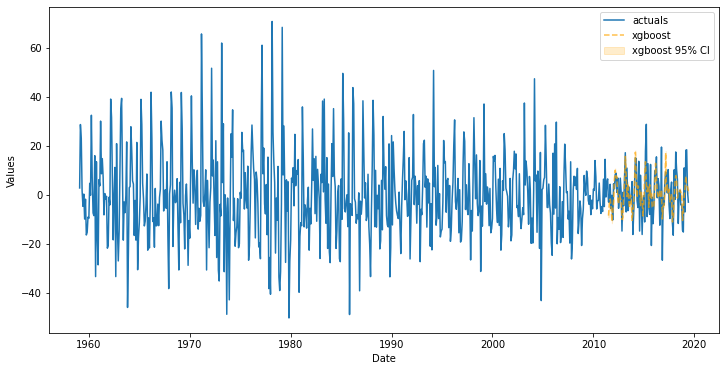

In [32]:
f.plot_test_set(ci=True,models=best_model)
plt.show()

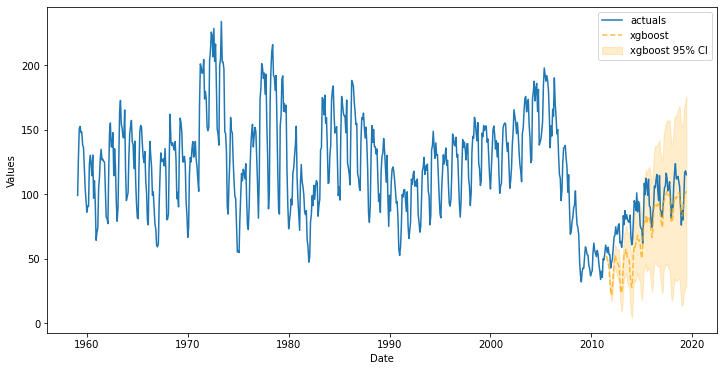

In [33]:
f.plot_test_set(ci=True,models=best_model,level=True)
plt.show()

In [34]:
housing_fcsts1 = f.export("lvl_fcsts",cis=True)
housing_results = score_cis(
    results_template.copy(),
    housing_fcsts1,
    'Bootstrapped (Default)',
    starts_sep,
    starts,
    val_len = val_len,
    m_ = 12, # monthly seasonality
)
housing_results

,Bootstrapped (Default)
mlr,22.048432
elasticnet,26.564580
ridge,22.876754
knn,30.289880
xgboost,17.523450
lightgbm,26.477929
gbt,18.770983


### Naive Interval

In [35]:
%%time
f.reeval_cis()

Wall time: 857 ms


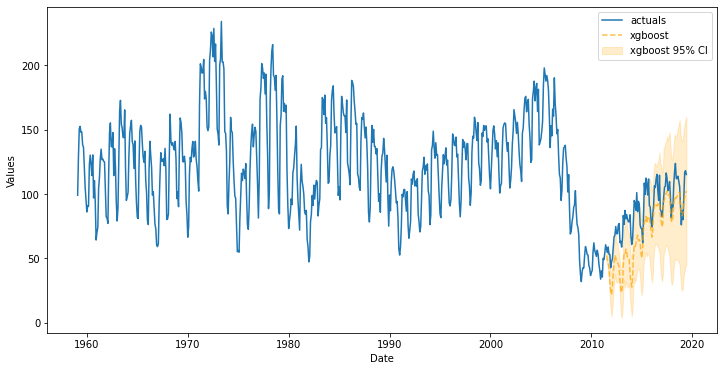

In [36]:
f.plot_test_set(ci=True,models=best_model,level=True)
plt.show()

In [37]:
housing_fcsts2 = f.export("lvl_fcsts",cis=True)
housing_results = score_cis(
    housing_results,
    housing_fcsts2,
    'Naive',
    starts_sep,
    starts,
    val_len = val_len,
    m_ = 12,
)
housing_results

,Bootstrapped (Default),Naive
mlr,22.048432,35.671601
elasticnet,26.564580,26.775855
ridge,22.876754,30.222527
knn,30.289880,30.823223
xgboost,17.523450,19.057930
lightgbm,26.477929,19.790794
gbt,18.770983,15.959118


### Backtested Interval

In [38]:
%%time
f.reeval_cis(method='backtest',jump_back=fcst_len)

Wall time: 1min 8s


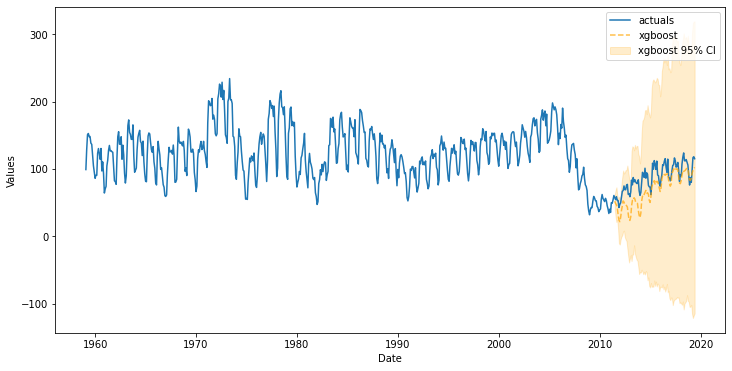

In [39]:
f.plot_test_set(ci=True,models=best_model,level=True)
plt.show()

In [40]:
housing_fcsts3 = f.export("lvl_fcsts",cis=True)
housing_results = score_cis(
    housing_results,
    housing_fcsts3,
    'Backtest',
    starts_sep,
    starts,
    val_len = val_len,
    m_ = 12,
)
housing_results

,Bootstrapped (Default),Naive,Backtest
mlr,22.048432,35.671601,6.491399
elasticnet,26.564580,26.775855,4.887020
ridge,22.876754,30.222527,5.825845
knn,30.289880,30.823223,5.335474
xgboost,17.523450,19.057930,5.121770
lightgbm,26.477929,19.790794,4.651980
gbt,18.770983,15.959118,5.727560


### Probabilistic Interval

In [41]:
for m in tqdm(models):
    f.set_estimator(m)
    f.proba_forecast(
        **ms.loc[ms['ModelNickname'] == m, 'HyperParams'].values[0], # grab the already-optimized hyperparams
        dynamic_testing = fcst_len,
    )

  0%|          | 0/7 [00:00<?, ?it/s]

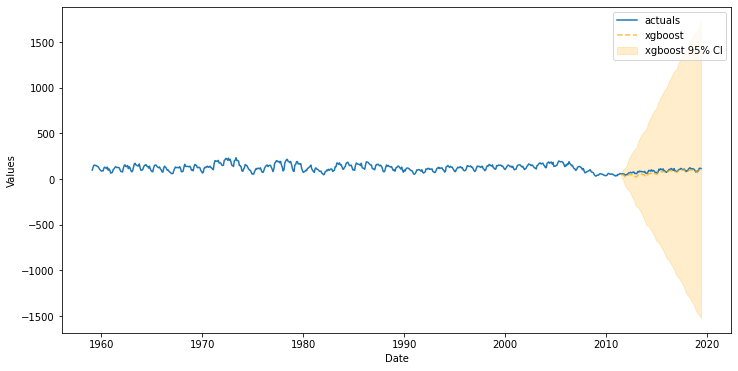

In [42]:
f.plot_test_set(ci=True,models=best_model,level=True)
plt.show()

In [43]:
housing_fcsts4 = f.export("lvl_fcsts",cis=True)
housing_results = score_cis(
    housing_results,
    housing_fcsts4,
    'Probabilistic',
    starts_sep,
    starts,
    val_len = val_len,
    m_ = 12,
)
housing_results

,Bootstrapped (Default),Naive,Backtest,Probabilistic
mlr,22.048432,35.671601,6.491399,24.309884
elasticnet,26.564580,26.775855,4.887020,22.467133
ridge,22.876754,30.222527,5.825845,24.144118
knn,30.289880,30.823223,5.335474,27.649174
xgboost,17.523450,19.057930,5.121770,22.996264
lightgbm,26.477929,19.790794,4.651980,21.032630
gbt,18.770983,15.959118,5.727560,22.221224


### Aggregated Results  

- Which type generally led to the best MSIS score?  
- For housing starts, it was the backtest method.  

In [44]:
housing_ci_type_score = housing_results.mean()
housing_ci_type_score.sort_values()

Backtest                   5.434436
Bootstrapped (Default)    23.507430
Probabilistic             23.545775
Naive                     25.471578
dtype: float64

In [45]:
housing_model_score = housing_results.mean(axis=1)
housing_model_score.sort_values()

gbt           15.669721
xgboost       16.174854
lightgbm      17.988333
elasticnet    20.173647
ridge         20.767311
mlr           22.130329
knn           23.524438
dtype: float64

## Avocado Sales  

- Link to data: https://www.kaggle.com/datasets/neuromusic/avocado-prices.  
- We will use a length of 13 observations (1 quarter) both to tune and test the models  
- We want to optimize the forecasts and confidence intervals for a 13-week forecast horizon  

In [46]:
val_len = 20
fcst_len = 20

In [47]:
avocados = pd.read_csv('avocado.csv',parse_dates = ['Date'])
volume = avocados.groupby('Date')['Total Volume'].sum()

In [48]:
volume_sep = volume.iloc[-fcst_len:]
volume = volume.iloc[:-fcst_len]

In [49]:
f = Forecaster(
    y = volume,
    current_dates = volume.index,
    future_dates = 13,
)

f.set_test_length(fcst_len)
f.set_validation_length(val_len)
f.diff()
f.auto_Xvar_select(
    estimator='elasticnet',
    alpha=.2,
    max_ar=26,
    monitor='ValidationMetricValue', # not test set
)
f

Forecaster(
    DateStartActuals=2015-01-04T00:00:00.000000000
    DateEndActuals=2017-11-05T00:00:00.000000000
    Freq=W-SUN
    N_actuals=149
    ForecastLength=13
    Xvars=['AR1', 'AR2', 'AR3', 'AR4', 'AR5', 'AR6', 'AR7', 'AR8', 'AR9', 'AR10', 'AR11', 'AR12', 'AR13']
    Differenced=1
    TestLength=20
    ValidationLength=20
    ValidationMetric=rmse
    ForecastsEvaluated=[]
    CILevel=0.95
    BootstrapSamples=100
    CurrentEstimator=None
    GridsFile=Grids
)

In [50]:
tune_test_forecast(
    f,
    models,
    dynamic_testing = fcst_len,
)

  0%|          | 0/7 [00:00<?, ?it/s]

In [51]:
ms = f.export('model_summaries',determine_best_by='LevelTestSetMAPE')
best_model = ms['ModelNickname'].values[0]
ms[['ModelNickname','LevelTestSetMAPE','LevelInSampleMAPE']]

,ModelNickname,LevelTestSetMAPE,LevelInSampleMAPE
0,knn,0.074231,1.887256e-01
1,lightgbm,0.271854,1.017392e-01
2,mlr,0.304476,2.827650e-01
3,ridge,0.307683,2.706258e-01
4,elasticnet,0.307851,2.688046e-01
5,xgboost,0.317365,6.947901e-08
6,gbt,0.398084,4.300351e-02


### Bootstrapped Interval (default)

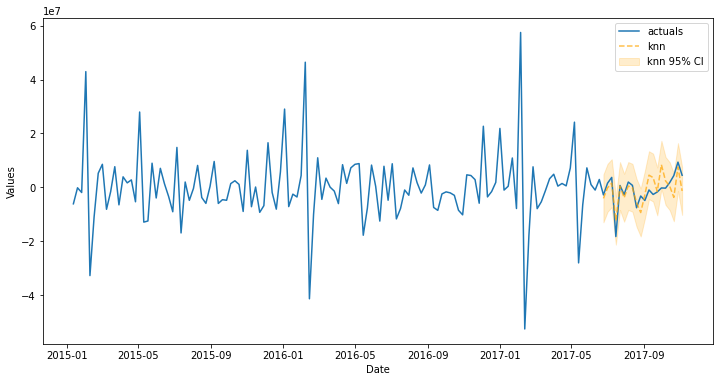

In [52]:
f.plot_test_set(ci=True,models=best_model)
plt.show()

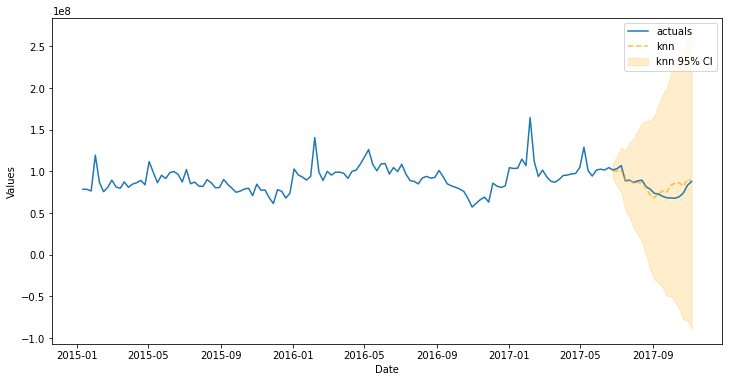

In [53]:
f.plot_test_set(ci=True,models=best_model,level=True)
plt.show()

In [54]:
avc_fcsts1 = f.export("lvl_fcsts",cis=True)
avc_results = score_cis(
    results_template.copy(),
    avc_fcsts1,
    'Bootstrapped (Default)',
    volume_sep,
    volume,
    val_len = val_len,
    models = models,
)
avc_results

,Bootstrapped (Default)
mlr,22.642388
elasticnet,20.238328
ridge,22.189354
knn,14.740249
xgboost,50.004332
lightgbm,11.426452
gbt,20.757615


### Naive Interval

In [55]:
%%time
f.reeval_cis()

Wall time: 395 ms


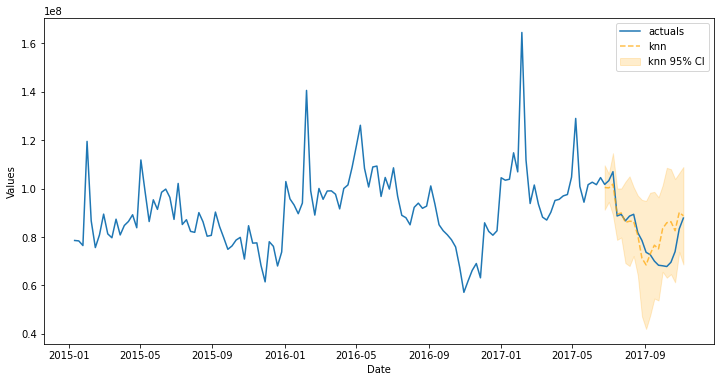

In [56]:
f.plot_test_set(ci=True,models=best_model,level=True)
plt.show()

In [57]:
avc_fcsts2 = f.export("lvl_fcsts",cis=True)
avc_results = score_cis(
    avc_results,
    avc_fcsts2,
    'Naive',
    volume_sep,
    volume,
    val_len = val_len,
    models = models,
)
avc_results

,Bootstrapped (Default),Naive
mlr,22.642388,17.385851
elasticnet,20.238328,17.203907
ridge,22.189354,17.231956
knn,14.740249,26.598951
xgboost,50.004332,18.186043
lightgbm,11.426452,21.328942
gbt,20.757615,17.241557


### Backtested Interval

In [58]:
%%time
f.reeval_cis(method='backtest')

Wall time: 13.7 s


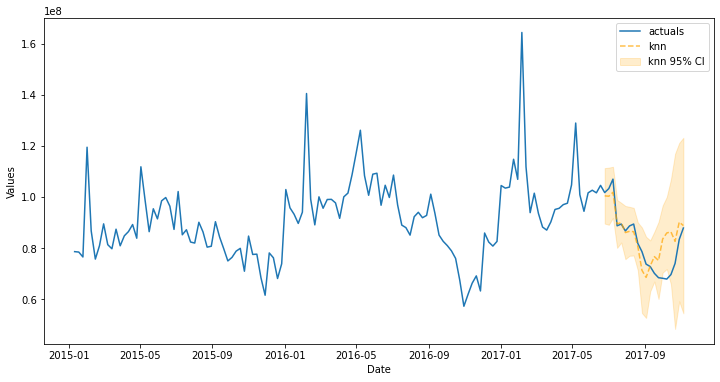

In [59]:
f.plot_test_set(ci=True,models=best_model,level=True)
plt.show()

In [60]:
avc_fcsts3 = f.export("lvl_fcsts",cis=True)
avc_results = score_cis(
    avc_results,
    avc_fcsts3,
    'Backtest',
    volume_sep,
    volume,
    val_len = val_len,
    models = models,
)
avc_results

,Bootstrapped (Default),Naive,Backtest
mlr,22.642388,17.385851,33.517170
elasticnet,20.238328,17.203907,32.550845
ridge,22.189354,17.231956,32.727489
knn,14.740249,26.598951,81.351821
xgboost,50.004332,18.186043,16.133034
lightgbm,11.426452,21.328942,29.387220
gbt,20.757615,17.241557,19.159082


### Probabilistic Interval

In [61]:
for m in tqdm(models):
    f.set_estimator(m)
    f.proba_forecast(
        **ms.loc[ms['ModelNickname'] == m, 'HyperParams'].values[0], # grab the already-optimized hyperparams
        dynamic_testing = fcst_len,
    )

  0%|          | 0/7 [00:00<?, ?it/s]

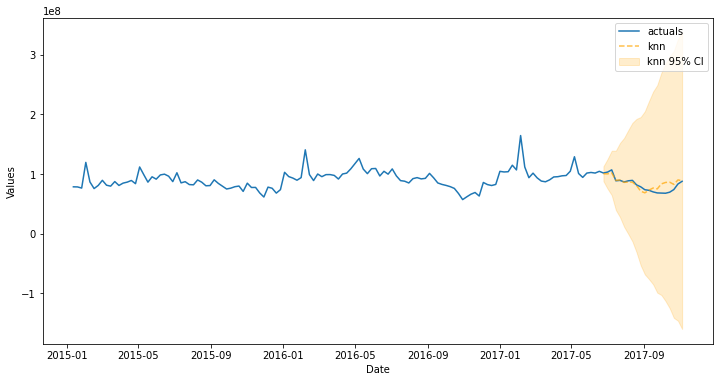

In [62]:
f.plot_test_set(ci=True,models=best_model,level=True)
plt.show()

In [63]:
avc_fcsts4 = f.export("lvl_fcsts",cis=True)
avc_results = score_cis(
    avc_results,
    avc_fcsts4,
    'Probabilistic',
    volume_sep,
    volume,
    val_len = val_len,
    models = models,
)
avc_results

,Bootstrapped (Default),Naive,Backtest,Probabilistic
mlr,22.642388,17.385851,33.517170,12.734511
elasticnet,20.238328,17.203907,32.550845,16.943060
ridge,22.189354,17.231956,32.727489,12.641916
knn,14.740249,26.598951,81.351821,15.170943
xgboost,50.004332,18.186043,16.133034,18.874086
lightgbm,11.426452,21.328942,29.387220,25.834093
gbt,20.757615,17.241557,19.159082,22.069380


### Aggregated Results  

- Which type generally led to the best MSIS score?  
- For avocados, it was the naive method.  

In [64]:
avc_ci_type_score = avc_results.mean()
avc_ci_type_score.sort_values()

Probabilistic             17.752570
Naive                     19.311030
Bootstrapped (Default)    23.142674
Backtest                  34.975237
dtype: float64

In [65]:
avc_model_score = avc_results.mean(axis=1)
avc_model_score.sort_values()

gbt           19.806908
ridge         21.197679
mlr           21.569980
elasticnet    21.734035
lightgbm      21.994177
xgboost       25.799374
knn           34.465491
dtype: float64

## All Aggregated Results
- All MSIS scores for each model on each series are stored in the below dataframe.

In [66]:
all_results = {
    'visitors':results,
    'housing starts':housing_results,
    'avocados':avc_results
}

all_results_df = pd.DataFrame()
for k, df in all_results.items():
    df['forecast of'] = k
    all_results_df = pd.concat(
        [all_results_df,df]
    )
    
all_results_df

,Bootstrapped (Default),Naive,Backtest,Probabilistic,forecast of
mlr,4.150189,5.557751,4.795872,3.576653,visitors
elasticnet,4.001752,5.510649,4.789591,3.509380,visitors
ridge,3.726014,5.532300,4.801673,3.575989,visitors
knn,3.593727,4.123267,4.515227,4.189418,visitors
xgboost,21.660044,6.532696,5.129796,5.323570,visitors
lightgbm,14.669521,7.180963,4.587335,5.678573,visitors
gbt,7.501384,5.214933,5.286061,3.230711,visitors
mlr,22.048432,35.671601,6.491399,24.309884,housing starts
elasticnet,26.564580,26.775855,4.887020,22.467133,housing starts
ridge,22.876754,30.222527,5.825845,24.144118,housing starts


In [67]:
all_results_df.mean().sort_values()

Backtest                  15.084441
Probabilistic             15.151081
Naive                     16.815753
Bootstrapped (Default)    18.373969
dtype: float64

Generally speaking, the backtest interval was the best, followed by naive, followed by bootstrapped. All three of them were fairly close to one another.  

In [68]:
models_pivoted = pd.pivot_table(
    all_results_df.reset_index(),
    index = 'index',
    values = all_results_df.columns.to_list()[:-1],
    aggfunc = np.mean,
    sort = False,
)
models_pivoted

,Bootstrapped (Default),Naive,Backtest,Probabilistic
index,,,,
mlr,16.280337,19.538401,14.934813,13.540349
elasticnet,16.934887,16.496804,14.075819,14.306524
ridge,16.264041,17.662261,14.451669,13.454008
knn,16.207952,20.515147,30.400841,15.669845
xgboost,29.729275,14.592223,8.794867,15.731307
lightgbm,17.524634,16.100233,12.875512,17.515099
gbt,15.676660,12.805203,10.057568,15.840438


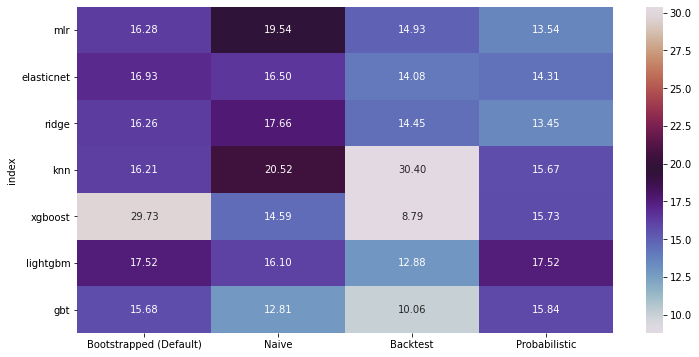

In [69]:
_, ax = plt.subplots(figsize=(12,6))
sns.heatmap(
    models_pivoted,
    annot=True,
    fmt='.2f',
    cmap="twilight",
    ax=ax
)
plt.show()

Bootstrapped intervals seem to have a good or bad score, without a lot in the middle. Naive is more in the middle of the three methods and most of the backtest intervals score well.

## Benchmark Against StatsModels ARIMA
- Confidence intervals come from StatsModels but the auto-ARIMA process is from [PMDARIMA](https://alkaline-ml.com/pmdarima/modules/generated/pmdarima.arima.auto_arima.html#pmdarima.arima.auto_arima).

In [70]:
from scalecast.auxmodels import auto_arima

In [71]:
all_series = {
    # series,out-of-sample series,seasonal step
    'visitors':[visits,visits_sep,1],
    'housing starts':[starts,starts_sep,12],
    'avocados':[volume,volume_sep,1]
}
arima_benchmark_results = pd.DataFrame()

In [72]:
for k, v in all_series.items():
    print(k)
    f = Forecaster(
        y=v[0],
        current_dates=v[0].index,
        future_dates=len(v[1])
    )
    auto_arima(f,m=v[2])
    cis = f.regr.get_forecast(len(v[1])).conf_int()
    arima_benchmark_results.loc[k,'MSIS'] = metrics.msis(
        a = v[1].values,
        uf = cis.T[1],
        lf = cis.T[0],
        obs = v[0].values,
        m = v[2],
    )

visitors
housing starts
avocados


In [73]:
arima_benchmark_results

,MSIS
visitors,5.790405
housing starts,5.624713
avocados,19.944485


In [74]:
arima_benchmark_results.mean()

MSIS    10.453201
dtype: float64

In [75]:
def highlight_rows(row):
    ret_row = ['']*5
    for i, c in enumerate(all_results_df.iloc[:,:-1]):
        if row[c] < row['ARIMA']:
            ret_row[i] = 'background-color: lightgreen;'
        else:
            ret_row[i] = 'background-color: lightcoral;'
    return ret_row

all_results_df_arima = all_results_df.merge(
    arima_benchmark_results.reset_index(),
    left_on='forecast of', 
    right_on = 'index', 
    how = 'left'
)

all_results_df_arima = all_results_df_arima.rename({'MSIS':'ARIMA'},axis=1)
all_results_df_arima = all_results_df_arima[all_results_df.columns.to_list()[:-1] + ['ARIMA']]
all_results_df_arima.index = all_results_df.reset_index()[['index','forecast of']].apply(lambda x: '-'.join(x),axis=1)

all_results_df_arima.style.apply(
    highlight_rows,
    axis=1,
)

,Bootstrapped (Default),Naive,Backtest,Probabilistic,ARIMA
mlr-visitors,4.150189,5.557751,4.795872,3.576653,5.790405
elasticnet-visitors,4.001752,5.510649,4.789591,3.509380,5.790405
ridge-visitors,3.726014,5.532300,4.801673,3.575989,5.790405
knn-visitors,3.593727,4.123267,4.515227,4.189418,5.790405
xgboost-visitors,21.660044,6.532696,5.129796,5.323570,5.790405
lightgbm-visitors,14.669521,7.180963,4.587335,5.678573,5.790405
gbt-visitors,7.501384,5.214933,5.286061,3.230711,5.790405
mlr-housing starts,22.048432,35.671601,6.491399,24.309884,5.624713
elasticnet-housing starts,26.564580,26.775855,4.887020,22.467133,5.624713
ridge-housing starts,22.876754,30.222527,5.825845,24.144118,5.624713


The above table shows which scalecast intervals performed better or worse than the ARIMA interval. It would seem sometimes a scalecast interval leads to better results than ARIMA would, sometimes not. Usually backtested and probabilistic intervals do. The other two methods usually do not. It is up to the user to use common sense to decide in what situations to use which confidence interval type.

When a series is transformed before forecasting, it can lead to a more distorted interval in scalecast. We saw that with the housing and avocados series. A nice seasonal and stationary series like the visitors series explored in this notebook can receive a more sound interval using less work to get it.

**Recommendation:**

Based on this analysis and my own observations from other analyses, I recommend using the probabilistic interval where possible. In other situations, or in situations where the conformal interval looks unbelievable, the backtested interval also performs well. The bootstrapped and naive intervals should only be used in situations where it isn't possible or there isn't enough time to construct the other interval types. 